In [5]:
%load_ext autoreload
%autoreload 2
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer
from rl_algorithms import *
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2.1

In [28]:
n_episodes = 20000
averaging_steps = 250
turns = np.array(['X','O'])

q_player = QPlayer(0.05, 0.99, 0.2)
env = TictactoeEnv()

rewards = []
average_reward = 0.

for episode in range(n_episodes):
        if episode % 5000 == 0:
            print('Current episode: %d' % episode)

        # Update players
        other_player = OptimalPlayer(epsilon=0.5, player=turns[1])

        # Play game
        reward = play_game(env, q_player, other_player, turns, testing=False)
        average_reward += reward

        if episode % averaging_steps == averaging_steps - 1:
            average_reward /= averaging_steps
            rewards.append(average_reward)
            average_reward = 0.

        # Change first player
        turns = turns[::-1]

Current episode: 0
Current episode: 5000
Current episode: 10000
Current episode: 15000
Current episode: 20000


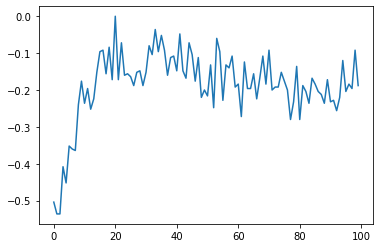

In [29]:
plt.plot(rewards)

# 2.1.1

In [9]:
n_episodes = 20000
averaging_steps = 250

env = TictactoeEnv()

n_star_rewards = []
n_star_list = [int(x) for x in np.linspace(1, n_episodes, 11)]
print(n_star_list)
n_star_M_opts = []
n_star_M_rands = []


for n_star in n_star_list:
    print('Current n_star: %d' % n_star)
    q_player = VariableEpsilonQPlayer(0.05, 0.99, 0.8, 0.1, n_star)

    turns = np.array(['X','O'])
    rewards = []
    M_opts = []
    M_rands = []

    average_reward = 0.

    for episode in range(n_episodes):
        if episode % 5000 == 0:
            print('Current episode: %d' % episode)


        # Update players
        q_player.update_epsilon(episode)
        other_player = OptimalPlayer(epsilon=0.5, player=turns[1])

        # Play game
        reward = play_game(env, q_player, other_player, turns, testing=False)
        average_reward += reward

        if episode % averaging_steps == averaging_steps - 1:
            average_reward /= averaging_steps
            rewards.append(average_reward)
            average_reward = 0.

            # Compute M_opt and M_rand
            M_opt, M_rand = compute_measures(env, q_player)
            M_opts.append(M_opt)
            M_rands.append(M_rand)

        # Change first player
        turns = turns[::-1]




    n_star_rewards.append(rewards)

[1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
Current n_star: 1
Current episode: 0


KeyboardInterrupt: 

TypeError: can only concatenate list (not "int") to list

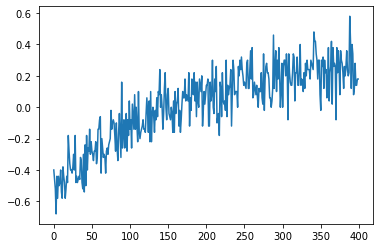

In [15]:
plt.plot(rewards)